In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from figurefirst import mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import odor_stat_calculations as osc

import pandas as pd
import os
import numpy as np

from scipy.spatial.distance import cdist
# from scipy import signal
from scipy.stats import kurtosis
import statsmodels.formula.api as smf
# from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
from concurrent.futures import ProcessPoolExecutor
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold

import joblib
from joblib import load, dump
import multiprocessing

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Save the trained model to a file
# dump(trained_models, '../assets/models/gpJan1diag17.joblib')


# Load the trained_models dictionary from the file
trained_models = load('../assets/models/gpNov22diag17.joblib')

### Gaussian Processes

### Continuous values prediction

In [19]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

def train_gp_for_file(file_path):
    # Load the data
    df = pd.read_hdf(file_path)
    
    # Subsample the data for faster training 
    data_subsample = df.sample(frac=1)
    X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
    y = data_subsample['odor'].values  
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)
    gp.fit(X, y)
    
    return gp, file_path

# Modify the folder path as needed
# folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
folder_path = "/home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

trained_models = {}

num_cores = 14  # Adjust based on your system
with ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = executor.map(train_gp_for_file, all_files)
    
    for gp_model, file_path in results:
        trained_models[file_path] = gp_model

print("Done")

 /home/vbl/pywork38/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
 /home/vbl/pywork38/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.


Done


### On Train Data

Mean Squared Error: 0.019140691776448494
Root Mean Squared Error: 0.13834988896435188
Mean Absolute Error: 0.053153616263586084
R-squared: 0.9755864595902042


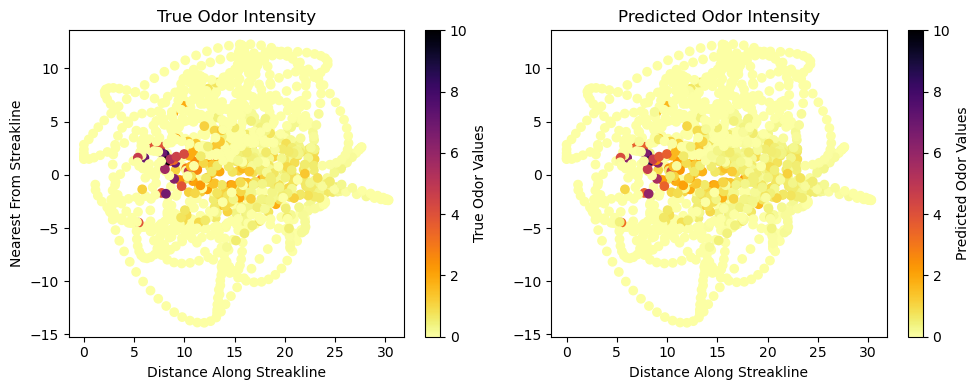

In [6]:
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag17.h5"

test_df = pd.read_hdf(test_file_path)

gp = trained_models[test_file_path]

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor'].values  # Use continuous odor values

# Make predictions using the retrieved GP model
y_pred_mean, y_pred_std = gp.predict(X_test, return_std=True)

# Regression Metrics
mse = mean_squared_error(y_true, y_pred_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred_mean)
r2 = r2_score(y_true, y_pred_mean)

# Printing the Metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


# Assuming y_pred_mean contains the continuous predicted odor values
y_pred_continuous = y_pred_mean  # Replace with your actual predictions

f, axes = plt.subplots(1, 2, figsize=(10, 4))

# True Odor Values (Continuous)
sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor'], cmap='inferno_r', vmin=0,vmax=10)  # Use actual odor values
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Intensity')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Values (Continuous)
sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_continuous, cmap='inferno_r',vmin=0,vmax=10)  # Use continuous predicted values
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Intensity')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()

In [6]:
x=pd.read_hdf('/home/beast/An/data/Sept13Plumes/plume1/train_raw/diag17.h5')
def calculate_distance_from_source(df):
    source = np.array([[0,0]])
    odor_position = np.array([[df.x[i],df.y[i]] for i in range (len(df))]) 

    distance_from_source = np.array([cdist(odor_position,source)]).flatten()
    df['distance_from_source'] = distance_from_source
    
    
calculate_distance_from_source(x)

In [7]:
osc.get_time_col(test_df,0.3)

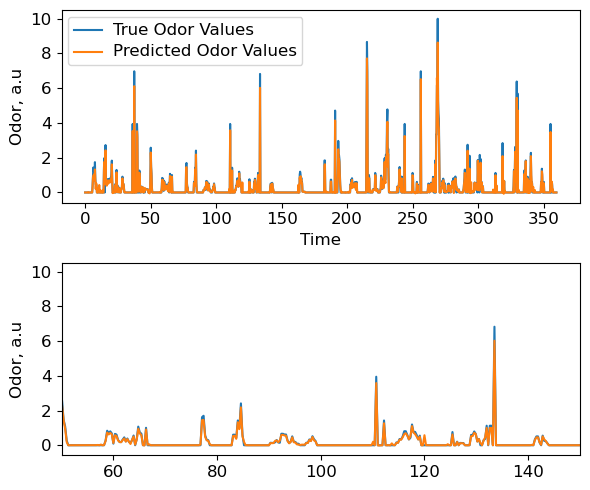

In [8]:
f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 5))

ax1.plot(test_df.time, test_df.odor, label ='True Odor Values')
ax1.plot(test_df.time, y_pred_continuous, label= 'Predicted Odor Values')
ax1.set_ylabel('Odor, a.u')
ax1.set_xlabel('Time')
ax1.legend()
mpl_functions.set_fontsize(ax1, 14)

ax2.plot(test_df.time, test_df.odor, label ='True Odor Values')
ax2.plot(test_df.time, y_pred_continuous, label= 'Predicted Odor Values')
ax2.set_ylabel('Odor, a.u')
# ax2.set_xlabel('Time')
# ax2.legend()
ax2.set_xlim([50, 150])
mpl_functions.set_fontsize(ax2, 12)
f.tight_layout()

In [9]:
store = np.array(x.distance_from_source.iloc[100:])
test_df['distance_from_source']=store

In [10]:
test_df['predicted_odor']=y_pred_continuous

In [11]:
# def mean_conc(df,index,dat):
#     #Distance
#     i = 0
#     mean_concentration = []
#     while i<len(index):
#         mean_concentration.append(np.mean(df.odor[index[i]])) 
#         i+=1
#     dat['mean_concentration']=mean_concentration

def cal_stat(df,index, index_predicted,fdf, fdf_predicted):
    osc.avg_distance(df,index,fdf)
    osc.mean_conc(df,index,fdf)
    osc.whiff_blank_duration(df,index,fdf)
    osc.std_whiff(df,index,fdf)
    osc.mean_avg(df,index,fdf)
    osc.encounter_frequency(df,index,fdf,1,2)
    osc.mean_t(df,index,fdf)
    
    osc.avg_distance(df,index_predicted,fdf_predicted)
    osc.predicted_mean_conc(df,index_predicted,fdf_predicted)
    osc.whiff_blank_duration(df,index_predicted,fdf_predicted)
    osc.std_whiff_predicted(df,index_predicted,fdf_predicted)
    osc.mean_avg_predicted(df,index_predicted,fdf_predicted)
    osc.encounter_frequency_predicted(df,index_predicted,fdf_predicted,1,2)
    osc.mean_t(df,index_predicted,fdf_predicted)
        
np.seterr(divide='ignore')
index = osc.get_index(test_df.odor,0.5)
index_predicted = osc.get_index(test_df.predicted_odor,0.5)
fdf = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(test_df,index,index_predicted,fdf, fdf_predicted)

fdf.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

In [12]:
fdf_predicted.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

#### Whiff Concentration

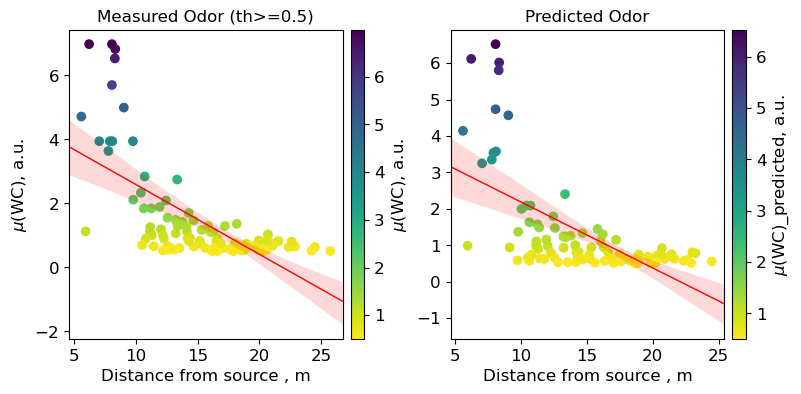

In [13]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.mean_concentration, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')


g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.mean_concentration , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_ylabel('$\mu$(WC), a.u.')
ax1.set_title('Measured Odor (th>=0.5)')

u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.mean_concentration, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r' )
# ax2.set_ylabel('Whiff Concentration, a.u.')


g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.mean_concentration , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

ax2.set_xlabel('Distance from source , m')
# ax2.set_ylabel('$\mu$(WC), a.u.')
ax2.set_title('Predicted Odor')
f.tight_layout(pad=1)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

#### Whiff Duration

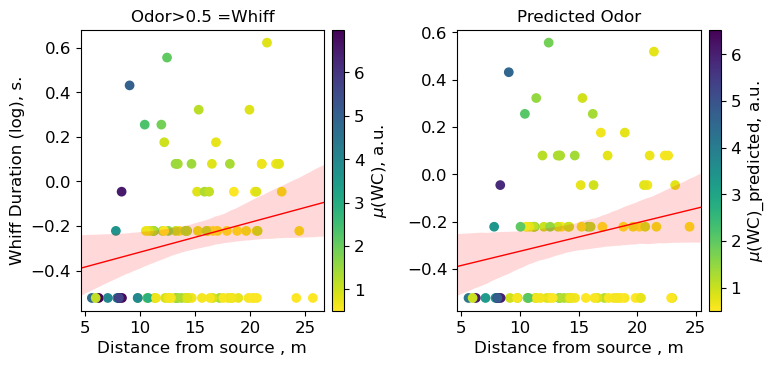

In [15]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.log_whiff, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.log_whiff , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('Whiff Duration (log), s.')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r' )

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

#### Whiff Frequency

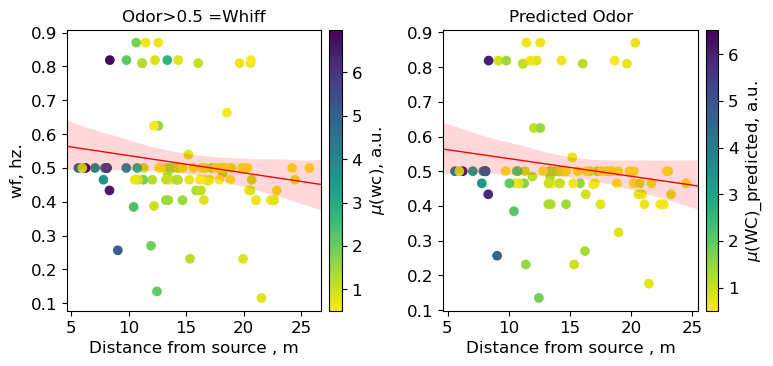

In [16]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.wf, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.wf , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(wc), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('wf, hz.')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.wf, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r' )

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.wf , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

#### Whiff Std Dev

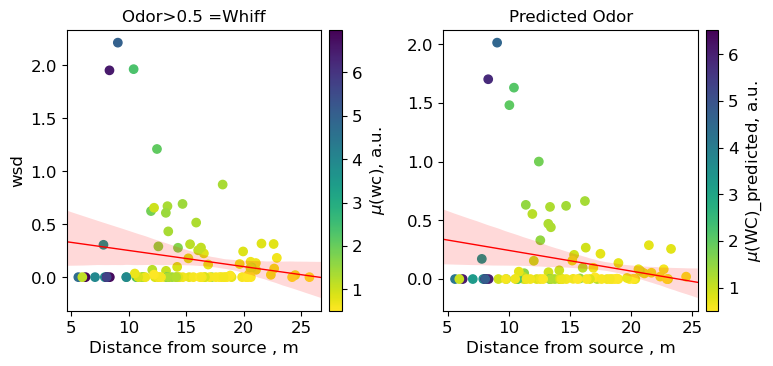

In [17]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.std_whiff, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.std_whiff , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(wc), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('wsd')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.std_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r' )

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.std_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

#### Whiff MA

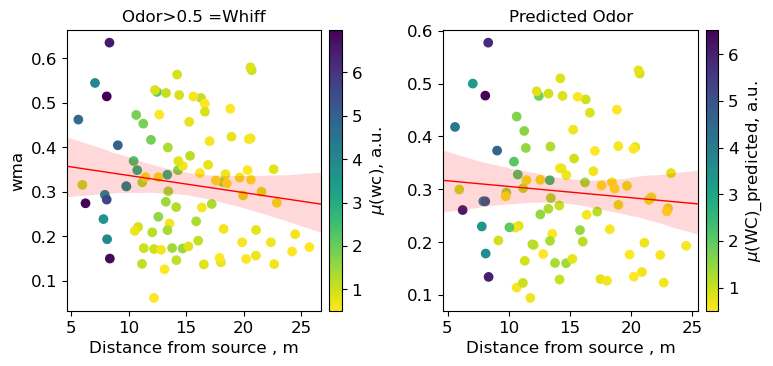

In [18]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.whiff_ma, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.whiff_ma , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(wc), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('wma')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.whiff_ma, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r' )

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.whiff_ma , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

#### Calculating Meta Stats

In [19]:
def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 10, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 10)  & (dataframe.avg_dist_from_source < 20), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 20, 'type'] = 2
    return dataframe

In [20]:
fdf_new = create_class_column(fdf)
fdf_predicted_new = create_class_column(fdf_predicted)


In [21]:
fdf_new.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time',
       'type'],
      dtype='object')

In [22]:
lookback_time = 3

trainset= fdf_new
# trainset= fdf_predicted_new

D_train=[]
mean_time_train=[]
Xtrain = []
ytrain = []
Nrows_train = []

for distance_class in [0,1,2]:
    Xtrain, ytrain, D_train,Nrows_train,mean_time_train = osc.gather_stat_timed(trainset,distance_class,
                      lookback_time, Xtrain,ytrain,D_train,Nrows_train,
                      mean_time_train)

In [23]:
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i]=np.ravel(X)
        
traindf['distance']=np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)



In [24]:
distance=smf.ols(formula=""" distance ~ mc_mean + ma_std_dev + ma_max + wd_std_dev """, data=traindf).fit()
print(distance.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     790.4
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          1.41e-286
Time:                        10:38:06   Log-Likelihood:                -2069.3
No. Observations:                 867   AIC:                             4149.
Df Residuals:                     862   BIC:                             4172.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.9743      0.262     87.660      0.0

In [27]:
lookback_time = 3

trainset_predicted= fdf_predicted_new
# trainset= fdf_predicted_new

D_train_predicted=[]
mean_time_train_predicted=[]
Xtrain_predicted = []
ytrain_predicted = []
Nrows_train_predicted = []

for distance_class in [0,1,2]:
    Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted,mean_time_train_predicted = osc.gather_stat_timed(trainset_predicted,distance_class,
                      lookback_time, Xtrain,ytrain,D_train,Nrows_train,
                      mean_time_train)

In [28]:
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf_predicted=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain_predicted)):
    if(np.size(Xtrain_predicted[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain_predicted[i])):
            X.append(calc_val(Xtrain_predicted[i][j]))
        traindf_predicted.loc[i]=np.ravel(X)
        
traindf_predicted['distance']=np.delete(D_train_predicted, c1)
traindf_predicted['mean_whiff_time'] = np.delete(mean_time_train_predicted, c1)
traindf_predicted['nwhiffs'] = np.delete(Nrows_train_predicted, c1)



In [29]:
distance=smf.ols(formula=""" distance ~ mc_mean + ma_std_dev + ma_max + wd_std_dev """, data=traindf_predicted).fit()
print(distance.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     1483.
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:38:29   Log-Likelihood:                -5207.6
No. Observations:                2051   AIC:                         1.043e+04
Df Residuals:                    2046   BIC:                         1.045e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.2734      0.211    105.592      0.0

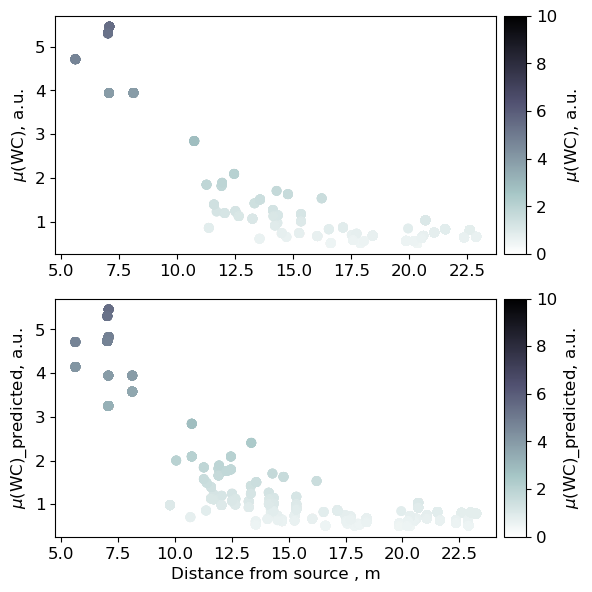

In [46]:
f,ax = plt.subplots(2,1,figsize=(6,6))


var1 =ax[0].scatter(traindf.distance, traindf.mc_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.mc_mean,c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
ax[0].set_ylabel('$\mu$(WC), a.u.')
ax[1].set_ylabel('$\mu$(WC)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


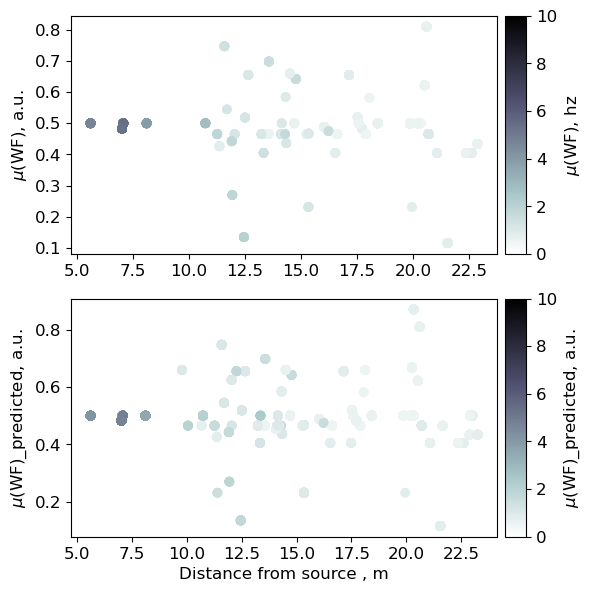

In [48]:
f,ax = plt.subplots(2,1,figsize=(6,6))


var1 =ax[0].scatter(traindf.distance, traindf.wf_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF), hz')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.wf_mean,c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
ax[0].set_ylabel('$\mu$(WF), a.u.')
ax[1].set_ylabel('$\mu$(WF)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


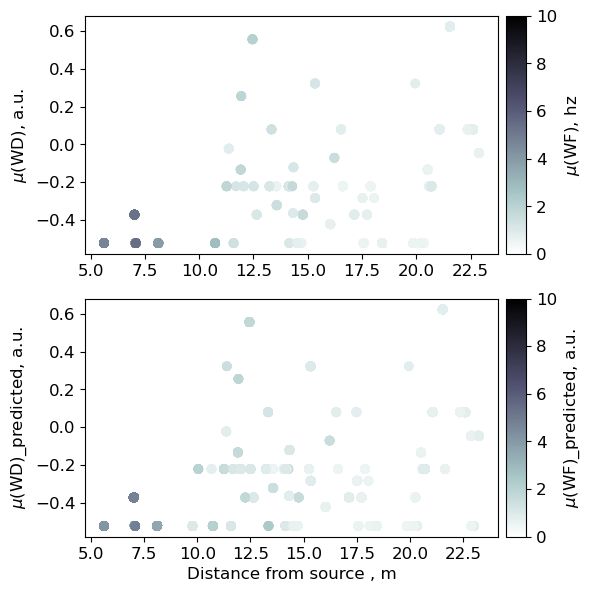

In [59]:
f,ax = plt.subplots(2,1,figsize=(6,6))


var1 =ax[0].scatter(traindf.distance, traindf.wd_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF), hz')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.wd_mean,c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
ax[0].set_ylabel('$\mu$(WD), a.u.')
ax[1].set_ylabel('$\mu$(WD)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


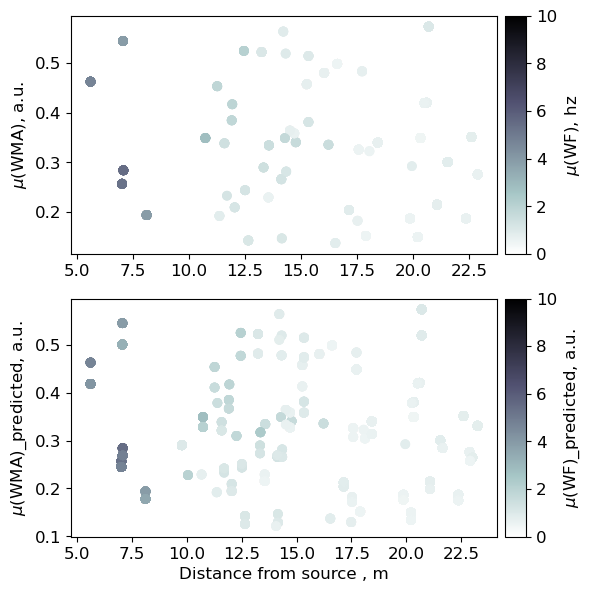

In [58]:
f,ax = plt.subplots(2,1,figsize=(6,6))


var1 =ax[0].scatter(traindf.distance, traindf.ma_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF), hz')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.ma_mean,c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
ax[0].set_ylabel('$\mu$(WMA), a.u.')
ax[1].set_ylabel('$\mu$(WMA)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


### Test Data

-0.7513569706718934


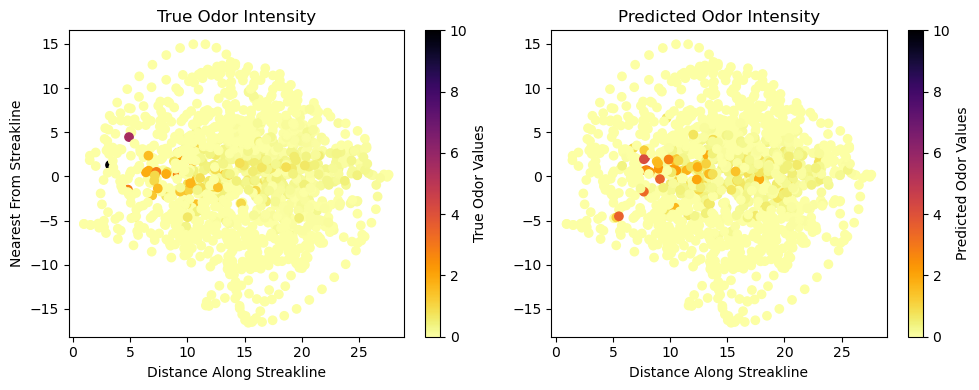

In [10]:
# Choose a representative trained model
representative_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag17.h5"
# representative_file_path = "/home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/diag17.h5"
gp_representative = trained_models[representative_file_path]

# Path to the new test file
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/diag1.h5"
# test_file_path = "/home/vbl/whileAtHome/data/Sept13Plumes/plume1/diag1.h5"
test_df = pd.read_hdf(test_file_path)

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor'].values

y_pred_mean, y_pred_std = gp_representative.predict(X_test, return_std=True)

# Regression Metrics
mse = mean_squared_error(y_true, y_pred_mean)
mae = mean_absolute_error(y_true, y_pred_mean)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred_mean)

print(r2)
# Setting the same scale for color bars
vmin = min(y_true.min(), y_pred_mean.min())
vmax = max(y_true.max(), y_pred_mean.max())

f, axes = plt.subplots(1, 2, figsize=(10, 4))

# True Odor Values (Continuous)
sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor'], cmap='inferno_r', vmin=0, vmax=10)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Intensity')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Values (Continuous)
sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_mean, cmap='inferno_r', vmin=0, vmax=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Intensity')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()

plt.show()

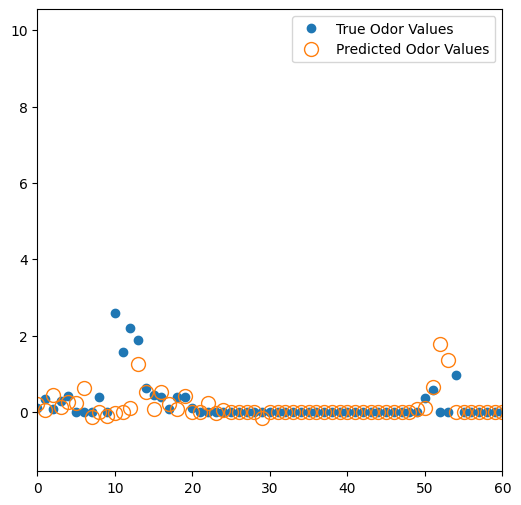

In [18]:
f,ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(test_df.odor, 'o', label ='True Odor Values')
ax.plot(y_pred_mean, 'o', fillstyle ='none', markersize=10, label ='Predicted Odor Values')
ax.set_xlim(0,60)
ax.legend()

### Using Cross Validation - Train Test Split

In [ ]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

def train_gp_for_file(file_path):
    df = pd.read_hdf(file_path)

    data_subsample = df.sample(frac=0.9)
    X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
    y = data_subsample['odor'].values

    n_splits = 5
    kf = KFold(n_splits=n_splits)

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)

    mse_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        gp.fit(X_train, y_train)
        y_pred = gp.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, y_pred))

    avg_mse = np.mean(mse_scores)
    print(f"Average MSE for {file_path}: {avg_mse}")
    gp.fit(X, y)
    
    return gp, file_path, avg_mse

folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]


trained_models = {}
avg_mse_values = {}  

num_cores = 10  
with ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = executor.map(train_gp_for_file, all_files)
    
    for gp_model, file_path, avg_mse in results:
        trained_models[file_path] = gp_model
        avg_mse_values[file_path] = avg_mse 
for file_path, mse in avg_mse_values.items():
    print(f"Average MSE for {file_path}: {mse}")

print("Training Complete")

In [ ]:
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag49.h5"
test_df = pd.read_hdf(test_file_path)

gp = trained_models[test_file_path]

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor'].values  # Use continuous odor values

# Make predictions using the retrieved GP model
y_pred_mean, y_pred_std = gp.predict(X_test, return_std=True)

# Regression Metrics
mse = mean_squared_error(y_true, y_pred_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred_mean)
r2 = r2_score(y_true, y_pred_mean)

# Printing the Metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Assuming y_pred_mean contains the continuous predicted odor values
y_pred_continuous = y_pred_mean  # Replace with your actual predictions

f, axes = plt.subplots(1, 2, figsize=(10, 4))

# True Odor Values (Continuous)
sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor'], cmap='inferno_r')  # Use actual odor values
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Intensity')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Values (Continuous)
sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_continuous, cmap='inferno_r')  # Use continuous predicted values
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Intensity')
axes[1].set_xlabel('Distance Along Streakline')

### On Test Data

In [ ]:
# Choose a representative trained model
representative_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag49.h5"
gp_representative = trained_models[representative_file_path]

# Path to the new test file
test_file_path = "/home/an/dataAnalysis/data/Sept13Plumes/plume1/test/diag10.h5"
test_df = pd.read_hdf(test_file_path)

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor'].values

y_pred_mean, y_pred_std = gp_representative.predict(X_test, return_std=True)

# Regression Metrics
mse = mean_squared_error(y_true, y_pred_mean)
mae = mean_absolute_error(y_true, y_pred_mean)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred_mean)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

y_pred_continuous = y_pred_mean  # Replace with your actual predictions

f, axes = plt.subplots(1, 2, figsize=(10, 4))

# True Odor Values (Continuous)
sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor'], cmap='inferno')  # Use actual odor values
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Intensity')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Values (Continuous)
sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_continuous, cmap='inferno')  # Use continuous predicted values
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Intensity')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()

### Binary value prediction

In [4]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-3, 1e2))

def train_gp_for_file(file_path):
    # Load the data
    df = pd.read_hdf(file_path)
    if 'odor_binary' not in df.columns:
        df['odor_binary'] = df['odor'].apply(lambda x: 10 if x > 0 else 0)
    
    # Subsample the data for faster training 
    data_subsample = df.sample(frac=0.9)
    X = data_subsample[['distance_along_streakline', 'nearest_from_streakline']].values
    y = data_subsample['odor_binary'].values  
    
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    
    # Scale the features
    X_scaled = scaler.fit_transform(X)
    
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=0.1)
    gp.fit(X_scaled, y)
    
    return gp, scaler, file_path

folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

trained_models = {}
scalers = {}

num_cores = 40
with ProcessPoolExecutor(max_workers=num_cores) as executor:
    results = executor.map(train_gp_for_file, all_files)
    
    for gp_model, scaler, file_path in results:
        trained_models[file_path] = gp_model
        scalers[file_path] = scaler
        # print(f"Completed training for file: {file_path}")
print("Done")

/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/beast/.local/lib/python3.10/site-packages/sklearn/gaussian_process/

Done


### Predict the odor values for the seen data

Accuracy: 0.7078571428571429
Classification report:               precision    recall  f1-score   support

           0       0.73      0.93      0.82       984
          10       0.52      0.19      0.27       416

    accuracy                           0.71      1400
   macro avg       0.63      0.56      0.55      1400
weighted avg       0.67      0.71      0.66      1400



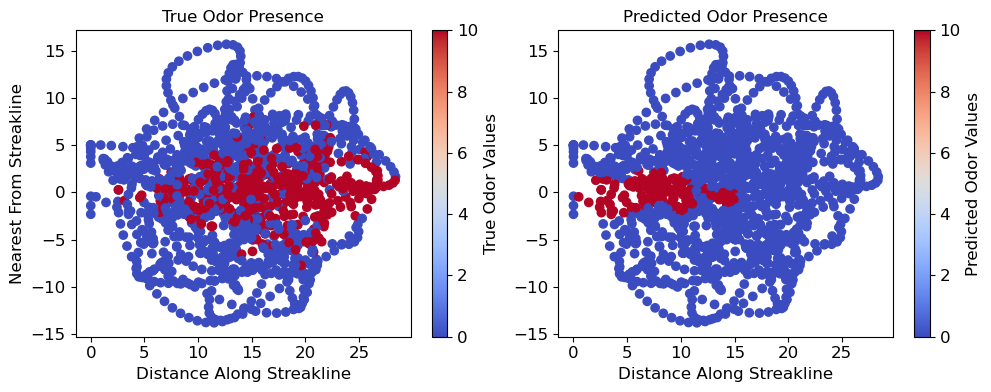

In [8]:
# Testing phase
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag39.h5"
test_df = pd.read_hdf(test_file_path)

gp = trained_models[test_file_path]

if 'odor_binary' not in test_df.columns:
    test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor_binary'].values

# Make predictions using the retrieved GP model
y_pred_mean, y_pred_std = gp.predict(X_test, return_std=True)
y_pred_binary = np.where(y_pred_mean > 0.1, 10, 0)

accuracy = accuracy_score(y_true, y_pred_binary)
report = classification_report(y_true, y_pred_binary)
print(f"Accuracy: {accuracy}")
print(f"Classification report: {report}")

f, axes = plt.subplots(1,2, figsize=(10, 4))

sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor_binary'], cmap='coolwarm')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')


sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_binary, cmap='coolwarm')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Presence')
axes[1].set_xlabel('Distance Along Streakline')
# axes[1].set_ylabel('Nearest From Streakline')

f.tight_layout()

mpl_functions.set_fontsize(f, 12)

### Prediction on a new data point with new plume

Accuracy: 0.8246153846153846
Classification report:               precision    recall  f1-score   support

           0       0.88      0.86      0.87       859
          10       0.73      0.76      0.75       441

    accuracy                           0.82      1300
   macro avg       0.80      0.81      0.81      1300
weighted avg       0.83      0.82      0.83      1300



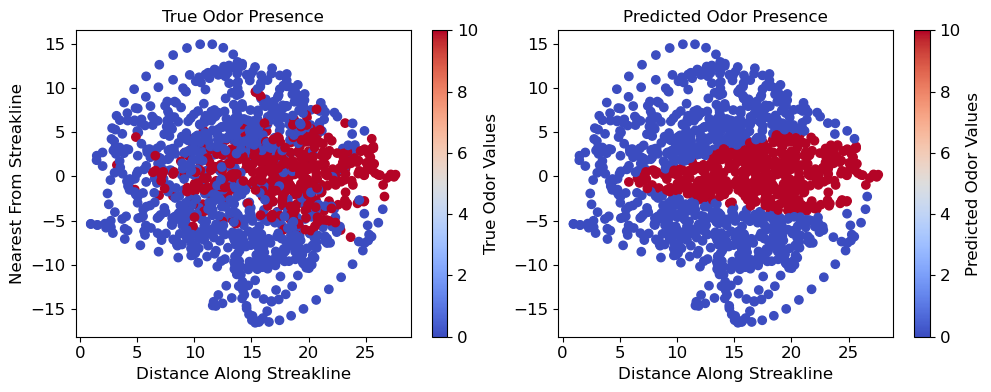

In [23]:
# Choose a representative trained model
representative_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag15.h5"  # Modify this to an actual training file path
gp_representative = trained_models[representative_file_path]

# Path to the new test file
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/diag1.h5"
test_df = pd.read_hdf(test_file_path)

if 'odor_binary' not in test_df.columns:
    test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
y_true = test_df['odor_binary'].values


y_pred_mean, y_pred_std = gp_representative.predict(X_test, return_std=True)
y_pred_binary = np.where(y_pred_mean > 4.5, 10, 0)

accuracy = accuracy_score(y_true, y_pred_binary)
report = classification_report(y_true, y_pred_binary)
print(f"Accuracy: {accuracy}")
print(f"Classification report: {report}")

f, axes = plt.subplots(1, 2, figsize=(10, 4))


sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor_binary'], cmap='coolwarm')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')


sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_binary, cmap='coolwarm')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Presence')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()

mpl_functions.set_fontsize(f, 12)

#### Using a average representation of the system ( not great )

In [17]:
# test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/diag1.h5"
# test_df = pd.read_hdf(test_file_path)

# if 'odor_binary' not in test_df.columns:
#     test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

# X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
# y_true = test_df['odor_binary'].values

# # Collect predictions from all trained models
# all_predictions = []

# for gp_model in trained_models.values():
#     y_pred_mean, _ = gp_model.predict(X_test, return_std=True)
#     y_pred_binary = np.where(y_pred_mean > 0, 10, 0)
#     all_predictions.append(y_pred_binary)

# # Average the predictions (or take a majority vote)
# # Here we're using the mean; you can also use other aggregation methods
# final_prediction = np.mean(all_predictions, axis=0)
# final_prediction_binary = np.where(final_prediction > 0, 10, 0)

# accuracy = accuracy_score(y_true, final_prediction_binary)
# print(f"Accuracy using all trained models: {accuracy}")


# f, axes = plt.subplots(1, 2, figsize=(10, 4))

# mask = test_df['odor_binary'] >= 0
# sc1 = axes[0].scatter(test_df['distance_along_streakline'][mask], test_df['nearest_from_streakline'][mask], 
#                       c=test_df['odor_binary'][mask], cmap='Blues')
# cbar1 = plt.colorbar(sc1, ax=axes[0])
# cbar1.set_label('True Odor Values')
# axes[0].set_title('True Odor Presence')
# axes[0].set_xlabel('Distance Along Streakline')
# axes[0].set_ylabel('Nearest From Streakline')

# mask_pred = y_pred_binary >= 0
# sc2 = axes[1].scatter(test_df['distance_along_streakline'][mask_pred], test_df['nearest_from_streakline'][mask_pred], 
#                       c=y_pred_binary[mask_pred], cmap='Blues')
# cbar2 = plt.colorbar(sc2, ax=axes[1])
# cbar2.set_label('Predicted Odor Values')
# axes[1].set_title('Predicted Odor Presence')
# axes[1].set_xlabel('Distance Along Streakline')
# # Omitting y-label for the second plot for clarity

# f.tight_layout()

# mpl_functions.set_fontsize(f, 12)

In [ ]:
# import matplotlib.patches as patches
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# df = pd.read_hdf("/home/beast/An/data/Sept13Plumes/plume1/train/diag19.h5")

# window_size_x = 5 
# step_size = 1
# x_min, x_max = df['distance_along_streakline'].min(), df['distance_along_streakline'].max()
# y_min, y_max = df['nearest_from_streakline'].min(), df['nearest_from_streakline'].max()

# fig, ax = plt.subplots(1, figsize=(4, 4))
# sc=ax.scatter(df.distance_along_streakline, df.nearest_from_streakline, c = df.odor, cmap= 'inferno', alpha=0.5)
# ax.set_xlim(-1, x_max+1)

# ax.set_ylim(-20,20)
# cbar = plt.colorbar(sc, ax=ax)

# rect = patches.Rectangle((x_min, y_min), window_size_x, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
# ax.set_xlabel('Distance Along Streakline')
# ax.set_ylabel('Nearest From Streakline')
# ax.set_title('Sliding Window Across Data')


# def animate(i):
#     x_start = x_min + i * step_size
#     rect.set_x(x_start) 
#     return rect,

# fig.tight_layout()
# anim = FuncAnimation(fig, animate, frames=int((x_max - x_min) / step_size), interval=200, blit=True)

# HTML(anim.to_jshtml())
# anim.save('../sliding_window.gif', writer='imagemagick', fps=5)